# Graph Database Exploration
* Author: Jeffery Brown
* Topic: Graph Database, Neo4j
* GitHub Repo: https://github.com/daddyjab/GraphDB_Notes


In [1]:
# Dependencies

# Standard
import pandas as pd
import numpy as np
import sys

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import show, output_file, output_notebook, save
from bokeh.plotting import figure

# Neo4j driver for Python
from py2neo import Graph

# Style settings
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', 100)

from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# DEVELOPMENT ENVIRONMENT

In [2]:
# Connect to graph database
# graph = Graph("bolt://localhost:7687", auth=("neo4j", "graphdb") )
# graph

In [3]:
# Retrieve the database schema
# graph.run("CALL db.schema()").data()

In [4]:
# query = "MATCH path=(p:Person)-[r:ACTED_IN]->(m:Movie) RETURN m.title AS `Movie Title`, p.name AS `Actor Name`, r.roles AS `Roles Performed`"
# m_df = graph.run(query).to_data_frame()
# m_df

In [5]:
# Start up the Neo4j Citations Sandbox environment
# Reference: https://neo4j.com/sandbox-v2/citations/
graph_cit = Graph("http://52.23.177.159:36710", auth=("neo4j", "depths-swabs-howls") )
graph_cit

<Graph database=<Database uri='http://52.23.177.159:36710' secure=False user_agent='py2neo/4.3.0 urllib3/1.24.3 Python/3.6.9-final-0 (win32)'> name='data'>

# EXPLORATORY DATA ANALYSIS

In [6]:
graph_cit.run("CALL db.labels()").data()

[{'label': 'Article'},
 {'label': 'Author'},
 {'label': 'Venue'},
 {'label': 'Node'}]

In [7]:
graph_cit.run("CALL db.relationshipTypes()").data()

[{'relationshipType': 'VENUE'},
 {'relationshipType': 'AUTHOR'},
 {'relationshipType': 'CITED'},
 {'relationshipType': 'FRIENDS'},
 {'relationshipType': 'CO_AUTHOR'}]

In [8]:
query_cit = "CALL db.schema.relTypeProperties()"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,relType,propertyName,propertyTypes,mandatory
0,:`VENUE`,None,None,False
1,:`AUTHOR`,None,None,False
2,:`CITED`,None,None,False
3,:`FRIENDS`,None,None,False
4,:`CO_AUTHOR`,year,[Long],True
5,:`CO_AUTHOR`,collaborations,[Long],True


In [9]:
query_cit = "CALL db.schema.nodeTypeProperties()"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,nodeType,nodeLabels,propertyName,propertyTypes,mandatory
0,:`Author`,[Author],name,[String],True
1,:`Venue`,[Venue],name,[String],True
2,:`Node`,[Node],name,[String],True
3,:`Article`,[Article],index,[String],True
4,:`Article`,[Article],title,[String],True
5,:`Article`,[Article],year,[Long],True
6,:`Article`,[Article],n_citation,[Long],False
7,:`Article`,[Article],abstract,[String],False
8,:`Article`,[Article],pagerank,[Double],True


In [10]:
# query="CALL dbms.security.listUsers()"
# query="CALL dbms.security.listRoles()"
# query="CALL dbms.security.listRoles()"
# query="CALL dbms.listConnections()"query_cit = "MATCH path=(n)-[r:AUTHOR]-(a) RETURN a, labels(a), n, labels(n), r, Type(r) LIMIT 10"
query_cit = "MATCH ()-[r]-() RETURN r LIMIT 10"
query_cit = "MATCH (n) RETURN labels(n), keys(n), size(keys(n)), count(*) ORDER BY size(keys(n)) DESC"
query_cit = "MATCH (n) RETURN properties(n) LIMIT 100"
query_cit = "MATCH (n) UNWIND keys(n) as key_item WITH key_item ORDER BY key_item RETURN collect(DISTINCT key_item) AS `Node Keys` LIMIT 10"
query_cit = "MATCH ()-[r]-() UNWIND keys(r) as key_item WITH key_item ORDER BY key_item RETURN collect(DISTINCT key_item) AS `Node Keys` LIMIT 10"
query_cit = "MATCH path=(a:Article)-[r]->(n) WHERE EXISTS (a.abstract) RETURN DISTINCT a.title AS `Article Title`, size(a.abstract) AS `Abstract Size`, a.abstract ORDER BY `Abstract Size` DESC LIMIT 10"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,Article Title,Abstract Size,a.abstract
0,Programming pearls,8810,From the Book:#R##N#PREFACE: #R##N#Computer programming has many faces. Fred Brooks paints the b...
1,A simple approach to specifying concurrent systems,8411,"Over the past few years, I have developed an approach to the formal specification of concurrent ..."
2,Intelligent support for the engineering of software (panel paper),7886,Engineers of large systems must be concerned with both design of new systems and maintenance of ...
3,NEST: a network simulation and prototyping testbed,7814,The Network Simulation Testbed (NEST) is a graphical environment for simulation and rapid-protot...
4,"Computing, research, and war: if knowledge is power, where is responsibility?",7613,"In the United States, artificial intelligence (AI) research is mainly a story about military sup..."
5,Reversing the landslide in computer-related degree programs,6796,Introduction There is growing concern that a technologically educated workforce will not be a...
6,The social influence model of technology adoption,6728,"Introduction Human innovation, in combination with the internet, networking, and communicatio..."
7,Understanding object-oriented: a unifying paradigm,6481,The need to develop and maintain large complex software systems in a competitive and dynamic env...
8,Becoming a computer scientist,6248,It is well known that women are significantly underrepresented in scientific fields in the Unite...
9,Model Predictive Control of regulation services from commercial buildings to the smart grid,6053,Model Predictive Control of Regulation Services from Commercial Buildings to the Smart Grid Mehd...


In [11]:
result = {"label": [], "count": []}
for label in graph_cit.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph_cit.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
3,Node,5
0,Article,51956
1,Author,80299


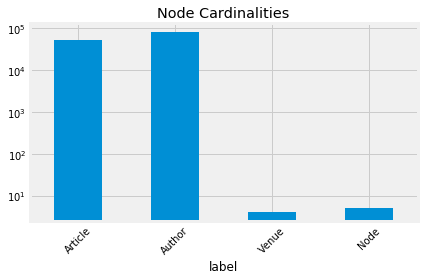

In [12]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
result = {"relType": [], "count": []}
for relationship_type in graph_cit.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph_cit.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
3,FRIENDS,6
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575
4,CO_AUTHOR,155224


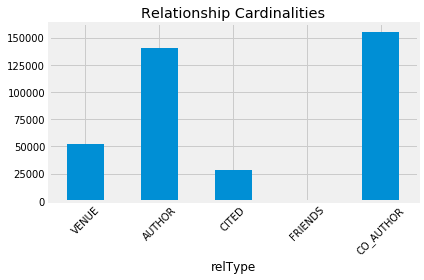

In [14]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, collect(DISTINCT author.name) AS author_list, collect(venue.name) AS venue_list, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY citationsReceived DESC, citationsGiven DESC
LIMIT 25
"""

graph_cit.run(exploratory_query).to_data_frame()

,article,author_list,venue_list,citationsGiven,citationsReceived
0,Rough sets,"[Roman Słowiński, Jerzy W. Grzymala-Busse, Zdzisław Pawlak, Wojciech Ziarko]","[Communications of The ACM, Communications of The ACM, Communications of The ACM, Communications...",0,211
1,A method for obtaining digital signatures and public-key cryptosystems,"[Adi Shamir, Leonard M. Adleman, Ronald L. Rivest]","[Communications of The ACM, Communications of The ACM, Communications of The ACM]",1,125
2,"Pastry: Scalable, Decentralized Object Location, and Routing for Large-Scale Peer-to-Peer Systems","[Antony I. T. Rowstron, Peter Druschel]","[Lecture Notes in Computer Science, Lecture Notes in Computer Science]",1,108
3,An axiomatic basis for computer programming,[C. A. R. Hoare],[Communications of The ACM],0,93
4,"Time, clocks, and the ordering of events in a distributed system",[Leslie Lamport],[Communications of The ACM],0,86
5,Symbolic execution and program testing,[James C. King],[Communications of The ACM],0,70
6,N degrees of separation: multi-dimensional separation of concerns,"[Peri L. Tarr, William H. Harrison, M Stanley Sutton, Harold Ossher]","[international conference on software engineering, international conference on software engineer...",0,68
7,Dynamically discovering likely program invariants to support program evolution,"[Michael D. Ernst, David Notkin, William G. Griswold, Jake Cockrell]","[international conference on software engineering, international conference on software engineer...",9,66
8,Software agents,"[Michael R. Genesereth, Steven P. Ketchpel]","[Communications of The ACM, Communications of The ACM]",0,63
9,Maintaining knowledge about temporal intervals,[James F. Allen],[Communications of The ACM],0,62


In [16]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph_cit.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


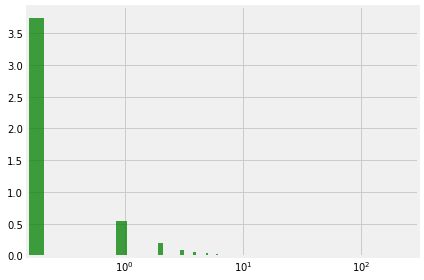

In [17]:
fig1, ax1 = plt.subplots()
# ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1000, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

In [18]:
query = """
MATCH (a:Article)
RETURN size((a)-[:CITED]->()) AS citations
"""

citation_df = graph_cit.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,1.301
min,0.000
25%,0.000
50%,0.000
75%,1.000
90%,2.000
99%,6.000
max,51.000


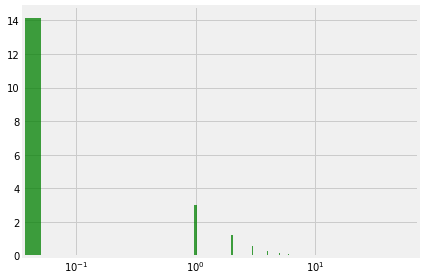

In [19]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1000, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

In [20]:
query = """
MATCH (p:Author)
RETURN size((p)<-[:AUTHOR]-(:Article)) AS n_publications
"""

pub_df = graph_cit.run(query).to_data_frame()
pub_df.describe([.25, .5, .75, .9, .99])

,n_publications
count,80299.000
mean,1.751
std,2.064
min,1.000
25%,1.000
50%,1.000
75%,2.000
90%,3.000
99%,10.000
max,89.000


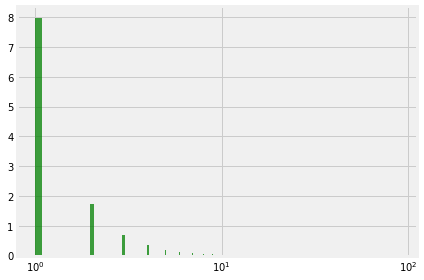

In [21]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(pub_df['n_publications'].dropna()), 1000, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

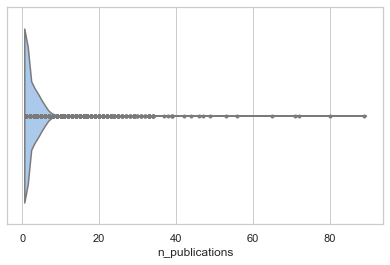

In [22]:
# Plot using seaborn
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(y="n_publications", inner='point', data=pub_df, orient='h')
# sns.despine(left=True)

# RECOMMENDATIONS

## Exercise 1: Coauthor Collaborative Filtering with Cypher
* Authors may be interested in reading other papers written by their coauthors.
* We can also recommend future collaborators by finding the people that their coauthors have collaborated with.

In [23]:
# Authors who have written the most articles
query = """
MATCH path=(p:Author)<-[:AUTHOR]-(:Article)
RETURN p.name AS name, count(path) AS n_pub
ORDER BY n_pub DESC, name LIMIT 1000
"""

authors_df = graph_cit.run(query).to_data_frame()
authors_df

,name,n_pub
0,Peter G. Neumann,89
1,Peter J. Denning,80
2,Moshe Y. Vardi,72
3,Pamela Samuelson,71
4,Bart Preneel,65
...,...,...
995,James R. Cordy,9
996,Jan Camenisch,9
997,Jan Vanthienen,9
998,Jean Cardinal,9


In [24]:
authors_df[ authors_df['name'].str.startswith('Brian') ]

,name,n_pub
240,Brian Fitzgerald,16
278,Brian Henderson-Sellers,15
741,Brian Warboys,10


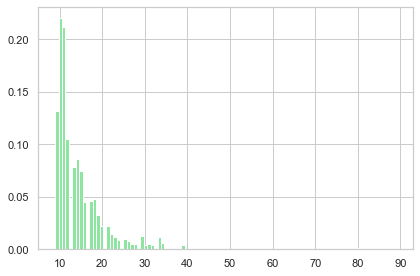

In [25]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(authors_df['n_pub'].dropna()), 100, density=True, facecolor='g', alpha=1.0)
# ax1.set_xscale("log")
plt.tight_layout()
plt.show()

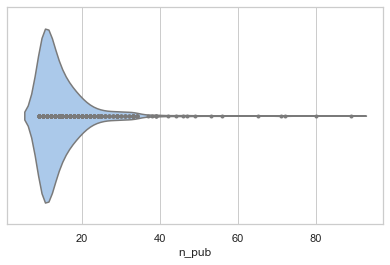

In [26]:
# Plot using seaborn
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(y="n_pub", inner='point', data=authors_df, orient='h')
# sns.despine(left=True)

In [27]:
# For one author, get the articles published and # of citations received for each article
q_args = {'authorName': authors_df['name'][0] }
q_args

{'authorName': 'Peter G. Neumann'}

In [28]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)
WHERE p.name=$authorName
RETURN  p.name AS name, a.title AS article, a.year as year, size( (a)<-[:CITED]-() ) AS n_cited
ORDER BY name, n_cited DESC, article LIMIT 20
"""

author_pubs_df = graph_cit.run(query, q_args).to_data_frame()
author_pubs_df

,name,article,year,n_cited
0,Peter G. Neumann,Security by obscurity,2003,2
1,Peter G. Neumann,"The foresight saga, redux",2012,2
2,Peter G. Neumann,Are dependable systems feasible,1993,1
3,Peter G. Neumann,"Computers, ethics, and values",1991,1
4,Peter G. Neumann,Crypto policy perspectives,1994,1
5,Peter G. Neumann,Information system security redux,2003,1
6,Peter G. Neumann,Risks of National Identity Cards,2001,1
7,Peter G. Neumann,Risks of automation: a cautionary total-system perspective of our cyberfuture,2016,1
8,Peter G. Neumann,Robust open-source software,1999,1
9,Peter G. Neumann,The foresight saga,2006,1


In [29]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)
WHERE p.name=$authorName
RETURN c.name AS collaborator, count(*) as n_collabs
ORDER BY n_collabs DESC, collaborator LIMIT 10
"""

collab_df = graph_cit.run(query, q_args).to_data_frame()
collab_df

,collaborator,n_collabs
0,Lauren Weinstein,3
1,Susan Landau,3
2,Whitfield Diffie,3
3,Matt Blaze,2
4,Rebecca T. Mercuri,2
5,Steven Michael Bellovin,2
6,Alfred Z. Spector,1
7,Anthony G. Lauck,1
8,Bruce Schneier,1
9,Clinton C. Brooks,1


In [30]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)<-[:AUTHOR]-(:Article)-[:AUTHOR]->(cc:Author)
WHERE
    p.name=$authorName
    AND p <> cc
    AND NOT ( (p)<-[:AUTHOR]-()-[:AUTHOR]->(cc) )
RETURN cc.name as `collaborator of collaborator`, count(*) as n_cc_collabs
ORDER BY n_cc_collabs DESC, `collaborator of collaborator` LIMIT 20
"""
#RETURN c.name AS collaborator, collect(DISTINCT cc.name), count(*) as n_cc_collabs

coc_df = graph_cit.run(query, q_args).to_data_frame()
coc_df

,collaborator of collaborator,n_cc_collabs
0,John Ioannidis,10
1,Scott Bradner,9
2,Angelos D. Keromytis,8
3,John Kelsey,7
4,Virgil D. Gligor,5
5,David K. Gifford,4
6,David Wagner,4
7,Gerald Jay Sussman,4
8,Omer Reingold,4
9,Peter Wolcott,4


In [31]:
# For one author, get the articles published and # of citations received for each article
q_args = {'authorName': authors_df['name'][240] }
q_args

{'authorName': 'Brian Fitzgerald'}

In [32]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)
WHERE p.name=$authorName
RETURN  p.name AS name, a.title AS article, a.year as year, size( (a)<-[:CITED]-() ) AS n_cited
ORDER BY name, n_cited DESC, article LIMIT 20
"""

author_pubs_df = graph_cit.run(query, q_args).to_data_frame()
author_pubs_df

,name,article,year,n_cited
0,Brian Fitzgerald,Continuous software engineering and beyond: trends and challenges,2014,3
1,Brian Fitzgerald,Grounded theory in software engineering research: a critical review and guidelines,2016,2
2,Brian Fitzgerald,Scaling agile methods to regulated environments: an industry case study,2013,2
3,Brian Fitzgerald,Software development method tailoring at Motorola,2003,2
4,Brian Fitzgerald,"Two's company, three's a crowd: a case study of crowdsourcing software development",2014,2
5,Brian Fitzgerald,Evidence-based decision making in lean software project management,2014,1
6,Brian Fitzgerald,Global software development: where are the benefits?,2009,1
7,Brian Fitzgerald,2nd international workshop on rapid continuous software engineering (RCoSE 2015),2015,0
8,Brian Fitzgerald,"Collaboration, conflict and control: the 4th workshop on open source software engineering",2004,0
9,Brian Fitzgerald,Experiences from Representing Software Architecture in a Large Industrial Project Using Model Dr...,2007,0


In [33]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)
WHERE p.name=$authorName
RETURN c.name AS collaborator, count(*) as n_collabs
ORDER BY n_collabs DESC, collaborator LIMIT 10
"""

collab_df = graph_cit.run(query, q_args).to_data_frame()
collab_df

,collaborator,n_collabs
0,Klaas-Jan Stol,6
1,Joseph Feller,5
2,Scott A. Hissam,4
3,Karim R. Lakhani,3
4,Walt Scacchi,2
5,Anders Mattsson,1
6,Andrea Capiluppi,1
7,André van der Hoek,1
8,Björn Lundell,1
9,Brian Lings,1


In [34]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)<-[:AUTHOR]-(:Article)-[:AUTHOR]->(cc:Author)
WHERE
    p.name=$authorName
    AND p <> cc
    AND NOT ( (p)<-[:AUTHOR]-()-[:AUTHOR]->(cc) )
RETURN cc.name as `collaborator of collaborator`, count(*) as n_cc_collabs
ORDER BY n_cc_collabs DESC, `collaborator of collaborator` LIMIT 20
"""
#RETURN c.name AS collaborator, collect(DISTINCT cc.name), count(*) as n_cc_collabs

coc_df = graph_cit.run(query, q_args).to_data_frame()
coc_df

,collaborator of collaborator,n_cc_collabs
0,Holger Giese,5
1,Chris Jensen,4
2,Gabriel A. Moreno,4
3,Grace A. Lewis,4
4,Judith A. Stafford,4
5,Kurt C. Wallnau,4
6,Robert C. Seacord,4
7,Gerald Bortis,3
8,Ivar Jacobson,3
9,Klaus Pohl,3


In [35]:
sum(coc_df['n_cc_collabs'] > 3)

7

## Exercise 2: Article Recommendations with Personalized PageRank
* PageRank is an algorithm that measures the transitive influence or connectivity of nodes. It can be computed by either iteratively distributing one node’s rank (originally based on degree) over its neighbors or by randomly traversing the graph and counting the frequency of hitting each node during these walks.
* Personalized PageRank (PPR) is a variant of this algorithm that is biased towards a set of source nodes. It is often used as part of building recommender systems.

In [36]:
# Assign PageRank properties to Article nodes based upon citings 
query = """
CALL algo.pageRank('Article', 'CITED')
"""
pr_list = graph_cit.run(query).data()
pr_list

[{'nodes': 51956,
  'iterations': 20,
  'loadMillis': 59,
  'computeMillis': 18,
  'writeMillis': 79,
  'dampingFactor': 0.85,
  'write': True,
  'writeProperty': 'pagerank'}]

In [37]:
# Find the top 10 articles based upon the above PageRank
query = f"""
MATCH (a:Article)
RETURN  a.title AS article, a.pagerank as pagerank, size( (a)<-[:CITED]-() ) AS n_cited
ORDER BY pagerank DESC, article LIMIT 10
"""

pagerank_df = graph_cit.run(query).to_data_frame()
pagerank_df

,article,pagerank,n_cited
0,A method for obtaining digital signatures and public-key cryptosystems,93.943,125
1,Secure communications over insecure channels,79.869,7
2,Rough sets,25.609,211
3,An axiomatic basis for computer programming,23.029,93
4,"Pastry: Scalable, Decentralized Object Location, and Routing for Large-Scale Peer-to-Peer Systems",21.470,108
5,SCRIBE: The Design of a Large-Scale Event Notification Infrastructure,19.486,14
6,A field study of the software design process for large systems,19.028,53
7,Productivity factors and programming environments,18.499,5
8,Analyzing medium-scale software development,16.453,5
9,A Calculus of Communicating Systems,15.431,55


In [38]:
# Choosig a specific author
q_args = {'authorName': authors_df['name'][0] }
q_args

{'authorName': 'Peter G. Neumann'}

In [39]:
# Find the top 10 articles for a specific author based on PageRank
query = """
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:CITED]->(n)
WHERE p.name = $authorName
WITH collect(a)+collect(n) AS sourceNodes
CALL algo.pageRank.stream('Article', 'CITED', {sourceNodes: sourceNodes} )
YIELD nodeId, score AS pagerank
RETURN algo.getNodeById(nodeId).title as article, pagerank
ORDER BY pagerank DESC, article LIMIT 10
"""

pp_rank_df = graph_cit.run(query, q_args).to_data_frame()
pp_rank_df

,article,pagerank
0,A technique for software module specification with examples,0.359
1,A messy state of the union: taming the composite state machines of TLS,0.332
2,Crypto policy perspectives,0.278
3,Password security: a case history,0.278
4,Public interest and the NII,0.278
5,Risks of automation: a cautionary total-system perspective of our cyberfuture,0.278
6,Risks of e-voting,0.278
7,The foresight saga,0.278
8,The challenges of partially automated driving,0.268
9,Proof techniques for hierarchically structured programs,0.248


In [40]:
# Drop the full text search index, if it already exists
query = """
CALL db.index.fulltext.drop('articles')
"""
try:
    index_result = graph_cit.run(query).data()
    index_result
    
except:
    # Get error details
    err_type = str(sys.exc_info()[0])
    err_msg = str(sys.exc_info()[1])
    
    # If failed to drop the index because it doesn't exist, then no problem
    # Otherwise, raise an error
    if "no such fulltext schema index" not in err_msg:
        raise

In [41]:
# Create a fill text search index on the title and abstract properties of all Article nodes
query = """
CALL db.index.fulltext.createNodeIndex('articles', ['Article'], ['title', 'abstract'] )
"""
index_result = graph_cit.run(query).data()
index_result

[]

In [42]:
# Confirm that the full-text search index has been created
query = """
CALL db.indexes()
YIELD description, indexName, tokenNames, properties, state, type, progress
WHERE type="node_fulltext"
RETURN *
"""

check_idx_df = graph_cit.run(query).to_data_frame()
check_idx_df

,description,indexName,progress,properties,state,tokenNames,type
0,"INDEX ON NODE:Article(title, abstract)",articles,6.269,"[title, abstract]",POPULATING,[Article],node_fulltext


In [43]:
# Example full text search
query = """
CALL db.index.fulltext.queryNodes("articles", "open source")
YIELD node, score
RETURN node.title, score, [(author)<-[:AUTHOR]-(node) | author.title] AS authors
LIMIT 10
"""
ex_ftsearch_df = graph_cit.run(query).to_data_frame()
ex_ftsearch_df

,node.title,score,authors
0,Progressive open source,4.252,"[None, None, None, None]"
1,Open source application spaces: the 5th workshop on open source software engineering,4.081,"[None, None, None, None, None]"
2,Reusing Open-Source Software and Practices: The Impact of Open-Source on Commercial Vendors,4.071,"[None, None]"
3,Software architecture in an open source world,3.815,[None]
4,From Research Software to Open Source,3.784,[None]
5,Open courseware and open source software,3.693,"[None, None, None]"
6,IBM's pragmatic embrace of open source,3.690,[None]
7,When to release in open source project,3.543,"[None, None]"
8,Increased security through open source,3.515,"[None, None]"
9,Robust open-source software,3.492,[None]


In [44]:
# Example: Authors with the most articles published that contain the full text search term
query = """
CALL db.index.fulltext.queryNodes("articles", "open source")
YIELD node, score
MATCH (node)-[:AUTHOR]->(author)
RETURN author.name, sum(score) AS totalScore, collect(node.title) AS articles
ORDER By totalScore DESC
LIMIT 20
"""

ex_auth_ftsearch_df = graph_cit.run(query).to_data_frame()
ex_auth_ftsearch_df

,author.name,totalScore,articles
0,Brian Fitzgerald,16.119,"[Open source application spaces: the 5th workshop on open source software engineering, The 3rd w..."
1,Joseph Feller,16.012,"[Open source application spaces: the 5th workshop on open source software engineering, The 3rd w..."
2,Walt Scacchi,10.731,"[Open source application spaces: the 5th workshop on open source software engineering, The futur..."
3,Daniel M. German,10.687,"[Open source-style collaborative development practices in commercial projects using GitHub, Mach..."
4,Scott A. Hissam,10.642,"[Open source application spaces: the 5th workshop on open source software engineering, The 3rd w..."
5,James D. Herbsleb,10.476,"[A case study of a corporate open source development model, Managing a corporate open source sof..."
6,Denys Poshyvanyk,8.907,"[Machine learning-based detection of open source license exceptions, Recommending source code fo..."
7,Margaret-Anne D. Storey,8.181,"[Understanding broadcast based peer review on open source software projects, Open source softwar..."
8,Peter C. Rigby,7.649,"[Understanding broadcast based peer review on open source software projects, Open source softwar..."
9,Ruchika Malhotra,7.132,"[An automated tool for generating change report from open-source software, Cross project change ..."


In [45]:
# Using full text search and personalized page rank to find intersting articles for different authors
query = """
MATCH (a:Author {name: $author})<-[:AUTHOR]-(article)-[:CITED]->(other)
WITH a, collect(article) + collect(other) AS sourceNodes
CALL algo.pageRank.stream(
  'CALL db.index.fulltext.queryNodes("articles", $searchTerm)
   YIELD node, score
   RETURN id(node) as id',
  'MATCH (a1:Article)-[:CITED]->(a2:Article) 
   RETURN id(a1) as source,id(a2) as target', 
  {sourceNodes: sourceNodes,graph:'cypher', params: {searchTerm: $searchTerm}})
YIELD nodeId, score
WITH algo.getNodeById(nodeId) AS n, score
WHERE not(exists((a)<-[:AUTHOR]-(n))) AND score > 0
RETURN n.title as article, score, [(n)-[:AUTHOR]->(author) | author.name][..5] AS authors
order by score desc limit 10
"""

q_args = {"author": "Tao Xie", "searchTerm": "open source"}

int_ftsearch_df = graph_cit.run(query, q_args).to_data_frame()
int_ftsearch_df

,article,score,authors
0,Static detection of cross-site scripting vulnerabilities,0.386,"[Zhendong Su, Gary Wassermann]"
1,Concern graphs: finding and describing concerns using structural program dependencies,0.278,"[Gail C. Murphy, Martin P. Robillard]"
2,Characterizing logging practices in open-source software,0.278,"[Ding Yuan, Soyeon Park, Yuanyuan Zhou]"
3,"Automated, contract-based user testing of commercial-off-the-shelf components",0.278,"[Lionel C. Briand, Yvan Labiche, Michal M. Sówka]"
4,Who should fix this bug,0.278,"[Lyndon Hiew, John Anvik, Gail C. Murphy]"
5,Conceptual module querying for software reengineering,0.236,"[Gail C. Murphy, Elisa L. A. Baniassad]"
6,Semantics-based code search,0.150,[Steven P. Reiss]
7,Bandera: extracting finite-state models from Java source code,0.150,"[Matthew B. Dwyer, Hongjun Zheng, James C. Corbett, Shawn Laubach, John Hatcliff]"
8,AsDroid: detecting stealthy behaviors in Android applications by user interface and program beha...,0.150,"[Lin Tan, Jianjun Huang, Xiangyu Zhang, Bin Liang, Peng Wang]"
9,EXSYST: search-based GUI testing,0.128,"[Andreas Zeller, Gordon Fraser, Florian Gross]"


In [46]:
params = {"author": "Marco Aurélio Gerosa", "searchTerm": "open source"}

int_ftsearch_df = graph_cit.run(query, q_args).to_data_frame()
int_ftsearch_df

,article,score,authors
0,Static detection of cross-site scripting vulnerabilities,0.386,"[Zhendong Su, Gary Wassermann]"
1,Concern graphs: finding and describing concerns using structural program dependencies,0.278,"[Gail C. Murphy, Martin P. Robillard]"
2,Characterizing logging practices in open-source software,0.278,"[Ding Yuan, Soyeon Park, Yuanyuan Zhou]"
3,"Automated, contract-based user testing of commercial-off-the-shelf components",0.278,"[Lionel C. Briand, Yvan Labiche, Michal M. Sówka]"
4,Who should fix this bug,0.278,"[Lyndon Hiew, John Anvik, Gail C. Murphy]"
5,Conceptual module querying for software reengineering,0.236,"[Gail C. Murphy, Elisa L. A. Baniassad]"
6,Semantics-based code search,0.150,[Steven P. Reiss]
7,Bandera: extracting finite-state models from Java source code,0.150,"[Matthew B. Dwyer, Hongjun Zheng, James C. Corbett, Shawn Laubach, John Hatcliff]"
8,AsDroid: detecting stealthy behaviors in Android applications by user interface and program beha...,0.150,"[Lin Tan, Jianjun Huang, Xiangyu Zhang, Bin Liang, Peng Wang]"
9,EXSYST: search-based GUI testing,0.128,"[Andreas Zeller, Gordon Fraser, Florian Gross]"


# PREDICTIONS

## Exercise 1: Running Link Prediction
* Use the Neo4j Browser interface to perform the Link Prediction exercise using:<br>`:play data-science-exercises`
* Reference: https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/linkprediction/
* 3 Approaches:
    * Common Neighbors: A measure of the number of common neighbors shared by a pair of nodes.<br>==> The intuition: 2 people are more likely to be introduced to each other if they have a higher number of friends in common
    * Adamic Adar: Computes the sum of the inverse log of the degree of each of the neighbors of a node, where the 'degree' of a node is the number of neighbors it has.<br>==> The intuition: 2 people are more likely to be introduced by a common friend if that common friend has fewer other friends.
    * Preferential Attachment: Computes the product of the degree of each node.<br>==> The Intuition: Nodes with lots of relationships will gain more relationships.
    

## Exercise 2: Building a Binary Classifier
* TBD

In [47]:
# For co-authors, add a CO_AUTHOR relationship with a property reflecting
# the year of first collaboration
query = """
CALL apoc.periodic.iterate(
    "MATCH (a1:Author)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
    WITH a1, a2, paper
    ORDER BY a1, paper.year
    RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
    "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
    SET coauthor.collaborations = collaborations",
    {batchSize: 1000} )
"""

q_results = graph_cit.run(query).stats()
q_results

ClientError: ProcedureCallFailed: Failed to invoke procedure `apoc.periodic.iterate`: Caused by: java.lang.OutOfMemoryError: Java heap space

In [ ]:
# Distribution of the first year that co-authors collaborated
# query = """
# MATCH (:Author)<-[c:CO_AUTHOR]-(:Author)
# RETURN toString(c.year) AS first_collab_year, count(*) AS n_collabs
# ORDER BY first_collab_year
# """
query = """
MATCH (:Author)<-[c:CO_AUTHOR]-(:Author)
RETURN c.year AS first_collab_year, count(*) AS n_collabs
ORDER BY first_collab_year
"""

co_auth_df = graph_cit.run(query).to_data_frame()
co_auth_df.describe()

In [ ]:
# Plot the distribution
fig = plt.figure(figsize=(20,10))
# ax1 = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)

# Column (bar) chart
ax = sns.barplot(x='first_collab_year',y='n_collabs', data=co_auth_df)
ax.set_title('# of Collaborations by First Year of Collaboration')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()

In [ ]:
# Similar plot using bokeh --> Displays in a separate browser window

# Capture output in a file (and then open in separate browser window)
#output_file(filename="docs/testing_bokeh.html", title="Example Bokeh Plot")

# Render output in the Jupyter noteboook cell
output_notebook()

p = figure(plot_height=350,
           title="# of Collaborations by First Year of Collaboration")

#p.vbar(x='first_collab_year', top='n_collabs', width=0.9, legend_label="# of Collaborations", source=co_auth_df)
p.vbar(x='first_collab_year', top='n_collabs', width=0.9, source=co_auth_df)

p.text(x='first_collab_year', y='n_collabs', text='n_collabs',
       text_color='black', text_align='center', text_alpha=0.75, 
       text_font_size='8pt', text_font_style='italic', text_font='calibri',
       source=co_auth_df[3::5])

p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

In [ ]:
# Training/Testing selection
# Based upon the chart above, will choose:
#    < 2006: Training Set => Add relationship CO_AUTHOR_EARLY
#   >= 2006: Testing Set => Add relationship CO_AUTHOR_LATE

# The following query results in memory exhaustion - punt, and look at the answer :(
# query = """
# MATCH (a1:Author)-[c:CO_AUTHOR]-(a2:Author)
# WHERE a1<>a2
# WITH c, a1, a2, 
#     CASE
#         WHEN c.year  < 2006 THEN 'CO_AUTHOR_EARLY'
#         WHEN c.year >= 2006 THEN 'CO_AUTHOR_LATE'
#     END
#         AS set_type
# WITH c, a1, a2, set_type
# CALL apoc.merge.relationship(a1, set_type, {}, {year:c.year}, a2)
# YIELD rel
# RETURN c.year, a1.name, a2.name, set_type
# ORDER BY c.year, a1.name, a2.name
# LIMIT 10
# """

In [ ]:
query = """
MATCH (a1:Author)-[c:CO_AUTHOR]->(a2:Author)
WHERE c.year < 2006
MERGE (a1)-[:CO_AUTHOR_EARLY {year: c.year}]-(a2)
"""
co_auth_df = graph_cit.run(query).to_data_frame()
co_auth_df.head(20)

In [ ]:
query = """
MATCH (a1:Author)-[c:CO_AUTHOR]->(a2:Author)
WHERE c.year >= 2006
MERGE (a1)-[:CO_AUTHOR_LATE {year: c.year}]-(a2)
"""
co_auth_df = graph_cit.run(query).to_data_frame()
co_auth_df.head(20)

In [ ]:
# Find out how many CO_AUTHOR related relationships are present
query = """
MATCH (:Author)-[c]-(:Author)
WHERE
    type(c) STARTS WITH "CO_AUTHOR"
RETURN type(c), count(*)
"""
co_auth_df = graph_cit.run(query).to_data_frame()
co_auth_df.head(20)